Импорт библиотек, функция set_seed() для воспроизводимости результатов, перенос вычислений на GPU

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
 
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import random
import os

def set_seed(SEED):
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    random.seed(SEED)
    np.random.seed(SEED) 
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
if not torch.cuda.is_available():
    cuda = False
else:
    cuda = True

device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


Функция create_symb_dict() для создания словаря, создание словарей транскрипции pron и буквосочетаний unigrams, bigrams и trigrams, выделение номеров столбцов таблицы для транскрипций pron_cols и буквенного представления alph_cols

In [3]:
def create_symb_dict(df, cols):
    symb_dict = {}
    
    def add2dict(key):
        if key in symb_dict:
            symb_dict[key] += 1
        else:
            symb_dict[key] = 0
            
    for col in cols:
        for word in df[col]:
            j = 0
            while j < len(word) - 1:
                if word[j + 1] == '̃':
                    add2dict(word[j:(j + 2)])
                    j += 2
                elif word[j] == '(':
                    add2dict(word[j:(j + 3)])
                    j += 3
                else:
                    add2dict(word[j])
                    j += 1
                    
            if j < len(word):
                add2dict(word[j])
    return symb_dict

verbs_df = pd.read_excel("IrrVerbs(parsing).xlsx")
verbs_df.drop_duplicates(inplace=True)
verbs_df.dropna(inplace=True)

pron_dict = create_symb_dict(verbs_df, verbs_df.columns[1::2])
pron = sorted(pron_dict.keys())

unigrams = list("abcdefghijklmnopqrstuvwxyzéèêîûïüç-")
bigrams = ['ai', 'au', 'ay', 'ch', 'ei', 'en', 'em', 'eu', 
           'gn', 'gu', 'il', 'in', 'im', 'oi', 'ou', 'oy', 
           'ph', 'qu', 'th', 'un', 'um', 'yn', 'ym']
trigrams = ['ail', 'aim', 'ain', 'eau', 'ill', 'oin']

pron_cols = [i for i in range(1, 14, 2)]
alph_cols = [i for i in range(0, 13, 2)]

Класс векторизатора

In [10]:
class Vectorizer(object):
    def __init__(self, n_grams):
        """
        Аргументы:
            n_grams: алфавит
        """
        self.n_grams = n_grams
        
        self.emb = {char: i + 1 for i, char in enumerate(n_grams)}
        self.emb['0'] = 0
        self._voc_size = len(self.emb)

    def get_voc_size(self):
        return self._voc_size

    def vectorize(self, word, vec_size):
        """Векторное представление слова
        Аргументы:
            word: обрабатываемое слово
            size: размер векторного представления
        """
        tokens = []
        word = word.replace('’', '')
        while word != '':
            if word[:3] in self.n_grams:
                tokens.append(word[:3])
                word = word[3:]
            elif word[:2] in self.n_grams:
                tokens.append(word[:2])
                word = word[2:]
            else:
                tokens.append(word[0])
                word = word[1:]  

        vec = np.zeros(vec_size, dtype=int)
        for i, char in enumerate(tokens):
            if char not in self.emb:
                print("Буквосочетания '{0}' нет в словаре".format(char))
                return None
            vec[i] = self.emb[char]
        return vec

Класс набора данных

In [11]:
class IrrVerbsDataset(Dataset):
    def __init__(self, verbs_df, vectorizer, test_size=0.1, seed=42):
        """
        Аргументы:
            verbs_df (pandas.DataFrame): набор данных
            vectorizer (WordsVectorizer): экземпляр векторизатора, 
                                          полученный на основе набора данных
        """
        self.verbs_df = verbs_df
        self._vectorizer = vectorizer

        self.test_df = self.verbs_df.sample(frac=test_size, random_state=seed)
        self.test_verbs_nums = sorted(list(self.test_df.index))
        self.test_size = len(self.test_df)

        self.train_df = self.verbs_df.drop(self.test_df.index)
        self.train_size = len(self.train_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        self.max_word_size()

    def max_word_size(self):
        """Вычисление максимальной длины слова"""
        max_len = 0
        for col in self.verbs_df.columns:
            for i in self.verbs_df.index:
                if len(str(self.verbs_df[col][i])) > max_len:
                    max_len = len(self.verbs_df[col][i])
        self.word_size = max_len


    @classmethod
    def load_dataset(cls, verbs_table, cols, vectorizer, test_size=0.1, seed=42):
        """Загружает набор данных
        Аргументы:
            verbs_table: местоположение набора данных
        Возвращает:
            экземпляр IrrVerbsDataset
        """
        verbs_df = pd.read_excel(verbs_table, usecols=cols)
        verbs_df.drop_duplicates(inplace=True)
        verbs_df.dropna(inplace=True)
        return cls(verbs_df, vectorizer, test_size, seed)

    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
            split (str): "train"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        inf_vector = self._vectorizer.vectorize(row[0], self.word_size)
        form_vector = np.concatenate([self._vectorizer.vectorize(word, self.word_size) 
                                      for word in row[1:]])
        
        return {"inf": inf_vector,
                "form": form_vector}

    def __len__(self):
        return self._target_size

Функция-генератор мини-батчей generate_batches() и функция оценки точности compute_accuracy()

In [12]:
def generate_batches(dataset, batch_size, shuffle=True, 
                     drop_last=True, device="cpu"):
    """
        Функция-генератор - адаптер для объекта Dataloader фреймворка PyTorch.
        Гарантирует размещение всех тензоров на нужном устройстве.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, 
                            shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict
        
def compute_accuracy(form_pred, form_real):
    form_real = form_real.cpu()
    form_pred = (torch.argmax(form_pred, 2)).cpu()
    n_correct = 0
    for i in range(len(form_real)):
        if all(form_pred[i] == form_real[i]):
            n_correct += 1
    return n_correct / len(form_real)

Класс модели LSTM

In [13]:
class LSTMInf2Forms(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_forms=6):
        super(LSTMInf2Forms, self).__init__()
        self.hidden_dim = hidden_dim
        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 
                          bidirectional=True, batch_first=True)
        self.hidden2tag = nn.ModuleList([nn.Linear(hidden_dim * 2, vocab_size) for _ in range(num_forms)])
 
    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = [hidden2tag(lstm_out) for hidden2tag in self.hidden2tag]
        return torch.cat(tag_space, dim=1)

Класс модели GRU

In [14]:
class GRUInf2Forms(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_forms=6):
        super(GRUInf2Forms, self).__init__()
        self.hidden_dim = hidden_dim
        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, 
                          bidirectional=True, batch_first=True)
        self.hidden2tag = nn.ModuleList([nn.Linear(hidden_dim * 2, vocab_size) for _ in range(num_forms)])
 
    def forward(self, sentence):
        embeds = self.char_embeddings(sentence)
        gru_out, _ = self.gru(embeds)
        tag_space = [hidden2tag(gru_out) for hidden2tag in self.hidden2tag]
        return torch.cat(tag_space, dim=1)

Класс экпериментов по оптимизации способа векторизации, архитектуры и скорости обучения модели

In [40]:
class Experiment():
    def __init__(self, model_name, emb_dim, hid_dim, batch_size,
                 data, cols, test_size, voc, seed):
        self.seed = seed
        self.vectorizer = Vectorizer(voc)
        self.dataset = IrrVerbsDataset.load_dataset(data, cols, self.vectorizer,
                                                    test_size=test_size, 
                                                    seed=self.seed)
        self.batch_size = batch_size
        self.num_forms = len(cols) - 1

        if model_name in ['GRU', 'LSTM']:
            self.model_name = model_name
            self.emb_dim = emb_dim
            self.hid_dim = hid_dim
        else:
            print("Неверно задан параметр model_name. Возможные значения: 'LSTM', 'GRU'")
        
    def lr_range_test(self, lr_start=1e-7, lr_end=1000, beta=0.98):
        set_seed(self.seed)

        self.dataset.set_split('train')
        num_batches = len(self.dataset) // self.batch_size
        batch_generator = generate_batches(self.dataset, 
                                           batch_size=self.batch_size, 
                                           device=device)
        if self.model_name == 'GRU':
            model = GRUInf2Forms(self.emb_dim, self.hid_dim, 
                                 self.vectorizer.get_voc_size(), 
                                 self.num_forms)
        elif self.model_name == 'LSTM':
            model = LSTMInf2Forms(self.emb_dim, self.hid_dim, 
                                  self.vectorizer.get_voc_size(), 
                                  self.num_forms)
        model.to(device)

        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr_start)

        lr_mult = lambda x: (lr_end / lr_start) ** (1 / num_batches)
        scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_mult)

        lr_loss = []
        lr = []
        avg_loss = 0
    
        model.train()

        for idx, batch in enumerate(batch_generator):
            optimizer.zero_grad()

            form_pred = model(batch['inf'])
            loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                             batch['form'].view(-1).to(torch.int64))
            loss_batch = loss.item()
            avg_loss = beta * avg_loss + (1 - beta) * loss_batch
            smoothed_loss = avg_loss / (1 - beta ** (idx + 1))
            lr_loss.append(smoothed_loss)
            lr.append(scheduler.get_last_lr()[0])

            loss.backward()
            optimizer.step()
            scheduler.step()

        return {'lr': lr, 
                'lr_loss': lr_loss}

    def constant_lr(self, lr, epoch=1000):
        set_seed(self.seed)

        if self.model_name == 'GRU':
            model = GRUInf2Forms(self.emb_dim, self.hid_dim, 
                                 self.vectorizer.get_voc_size(), 
                                 self.num_forms)
        elif self.model_name == 'LSTM':
            model = LSTMInf2Forms(self.emb_dim, self.hid_dim, 
                                  self.vectorizer.get_voc_size(),
                                  self.num_forms)
        model.to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for _ in trange(epoch, desc='iter'):
            self.dataset.set_split('train')
            batch_generator = generate_batches(self.dataset, 
                                               batch_size=self.batch_size, 
                                               device=device)
            running_loss = 0.0
            running_acc = 0.0
            model.train()

            for idx, batch in enumerate(batch_generator):
                optimizer.zero_grad()

                form_pred = model(batch['inf'])
                loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                                 batch['form'].view(-1).to(torch.int64))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)
                acc_batch = compute_accuracy(form_pred, batch['form'])
                running_acc += (acc_batch - running_acc) / (idx + 1)
                loss.backward()
                optimizer.step()

            train_loss.append(running_loss)
            train_acc.append(running_acc)

            self.dataset.set_split('test')
            batch_generator = generate_batches(self.dataset, 
                                               batch_size=self.batch_size,
                                               shuffle=False, drop_last=False,
                                               device=device)
            running_loss = 0.0
            running_acc = 0.0
            model.eval()

            for idx, batch in enumerate(batch_generator):

                form_pred = model(batch['inf'])
                loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                                 batch['form'].view(-1).to(torch.int64))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)
                acc_batch = compute_accuracy(form_pred, batch['form'])
                running_acc += (acc_batch - running_acc) / (idx + 1)

            val_loss.append(running_loss)
            val_acc.append(running_acc)

        return {'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc}

    def cyclic_lr(self, base_lr, max_lr, mode='triangular', epoch=1000):
        set_seed(self.seed)

        if self.model_name == 'GRU':
            model = GRUInf2Forms(self.emb_dim, self.hid_dim, 
                                 self.vectorizer.get_voc_size(),
                                 self.num_forms)
        elif self.model_name == 'LSTM':
            model = LSTMInf2Forms(self.emb_dim, self.hid_dim, 
                                  self.vectorizer.get_voc_size(),
                                  self.num_forms)
        model.to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=base_lr)
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr,
                                                mode=mode, gamma=0.9994,  
                                                step_size_up=80, 
                                                cycle_momentum=False)

        
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        lr = []

        for _ in trange(epoch, desc='iter'):
            self.dataset.set_split('train')
            batch_generator = generate_batches(self.dataset, 
                                               batch_size=self.batch_size, 
                                               device=device)
            running_loss = 0.0
            running_acc = 0.0
            model.train()

            for idx, batch in enumerate(batch_generator):
                optimizer.zero_grad()

                form_pred = model(batch['inf'])
                loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                                 batch['form'].view(-1).to(torch.int64))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)
                acc_batch = compute_accuracy(form_pred, batch['form'])
                running_acc += (acc_batch - running_acc) / (idx + 1)
                loss.backward()
                optimizer.step()
                lr.append(scheduler.get_last_lr())
                scheduler.step()

            train_loss.append(running_loss)
            train_acc.append(running_acc)

            self.dataset.set_split('test')
            batch_generator = generate_batches(self.dataset, 
                                               batch_size=self.batch_size,
                                               shuffle=False, drop_last=False,
                                               device=device)
            running_loss = 0.0
            running_acc = 0.0
            model.eval()

            for idx, batch in enumerate(batch_generator):

                form_pred = model(batch['inf'])
                loss = loss_func(form_pred.view(-1, form_pred.size(-1)),
                                 batch['form'].view(-1).to(torch.int64))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)
                acc_batch = compute_accuracy(form_pred, batch['form'])
                running_acc += (acc_batch - running_acc) / (idx + 1)

            val_loss.append(running_loss)
            val_acc.append(running_acc)

        return {'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'lr': lr}

    def opt_AdamW(self, epoch=1000):
        set_seed(self.seed)

        if self.model_name == 'GRU':
            model = GRUInf2Forms(self.emb_dim, self.hid_dim, 
                                 self.vectorizer.get_voc_size(),
                                 self.num_forms)
        elif self.model_name == 'LSTM':
            model = LSTMInf2Forms(self.emb_dim, self.hid_dim, 
                                  self.vectorizer.get_voc_size(),
                                  self.num_forms)
        model.to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters())
        
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        for _ in trange(epoch, desc='iter'):
            self.dataset.set_split('train')
            batch_generator = generate_batches(self.dataset, 
                                               batch_size=self.batch_size, 
                                               device=device)
            running_loss = 0.0
            running_acc = 0.0
            model.train()

            for idx, batch in enumerate(batch_generator):
                optimizer.zero_grad()

                form_pred = model(batch['inf'])
                loss = loss_func(form_pred.view(-1, form_pred.size(-1)), 
                                 batch['form'].view(-1).to(torch.int64))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)
                acc_batch = compute_accuracy(form_pred, batch['form'])
                running_acc += (acc_batch - running_acc) / (idx + 1)
                loss.backward()
                optimizer.step()

            train_loss.append(running_loss)
            train_acc.append(running_acc)

            self.dataset.set_split('test')
            batch_generator = generate_batches(self.dataset, 
                                               batch_size=self.batch_size,
                                               shuffle=False, drop_last=False,
                                               device=device)
            running_loss = 0.0
            running_acc = 0.0
            model.eval()

            for idx, batch in enumerate(batch_generator):

                form_pred = model(batch['inf'])
                loss = loss_func(form_pred.view(-1, form_pred.size(-1)),
                                 batch['form'].view(-1).to(torch.int64))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (idx + 1)
                acc_batch = compute_accuracy(form_pred, batch['form'])
                running_acc += (acc_batch - running_acc) / (idx + 1)

            val_loss.append(running_loss)
            val_acc.append(running_acc)

        return {'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc}

Для получения данных эксперимента по оптимизации способа векторизации, архитектуры и скорости обучения модели необходимо:
- установить параметр архитектуры MODEL ('LSTM', 'GRU')
- установить параметры способа векторизации:
    - COLUMNS (alph_cols при использовании буквенного представления, pron_cols при использовании транскрипции)
    - VOCABULARY (unigrams для униграмм, unigrams+bigrams для биграмм, unigrams+bigrams+trigrams для триграмм или pron для транскрипции)
    - VEC_TYPE ('unigrams' для униграмм, 'bigrams' для биграмм, 'trigrams' для триграмм или 'transcription' для транскрипции)
- установить параметры скорости обучения:
    - LR ([2, 3, 4, 5, 10, 15, 20] для буквенного представления, [2, 3, 4, 5, 6, 7, 8] для транскрипции)
    - MAX_LR (20 для буквенного представления, 8 для транскрипции)

После выполнения кода в ячейке данные экспериментов сохранятся в файлах.

In [ ]:
MODEL = 'GRU' #'LSTM'
EMBEDDING_DIM = 16
HIDDEN_DIM = 32
BATCH_SIZE = 16

DATA = "IrrVerbs(parsing).xlsx"
COLUMNS = alph_cols #pron_cols
TEST_SIZE = 0.1
VOCABULARY = unigrams#+bigrams+trigrams #pron

SEED = 42
VEC_TYPE = 'unigrams' #'bigrams' #'trigrams' #'transcription'

LR = [2, 3, 4, 5, 10, 15, 20] #[2, 3, 4, 5, 6, 7, 8]
CLR_MODE = ['triangular', 'triangular2', 'exp_range']
BASE_LR = 2
MAX_LR = 20 #8

experiment = Experiment(MODEL, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE,
                        DATA, COLUMNS, TEST_SIZE, VOCABULARY, SEED)

lrrt_res = experiment.lr_range_test()
np.save('lr_{0}_{1}_{2}'.format(MODEL, VEC_TYPE, SEED), 
        lrrt_res['lr'])
np.save('lr_loss_{0}_{1}_{2}'.format(MODEL, VEC_TYPE, SEED), 
        lrrt_res['lr_loss'])

for lr in LR:
    const_lr_res = experiment.constant_lr(lr)
    np.save('train_acc_{0}_{1}_{2}_const_lr_{3}'.format(MODEL, VEC_TYPE, 
                                                        SEED, lr), 
            const_lr_res['train_acc'])
    np.save('train_loss_{0}_{1}_{2}_const_lr_{3}'.format(MODEL, VEC_TYPE, 
                                                         SEED, lr), 
            const_lr_res['train_loss'])
    np.save('val_acc_{0}_{1}_{2}_const_lr_{3}'.format(MODEL, VEC_TYPE, 
                                                      SEED, lr), 
            const_lr_res['val_acc'])
    np.save('val_loss_{0}_{1}_{2}_const_lr_{3}'.format(MODEL, VEC_TYPE, 
                                                       SEED, lr), 
            const_lr_res['val_loss'])

for mode in CLR_MODE:
    clr_res = experiment.cyclic_lr(BASE_LR, MAX_LR, mode)
    np.save('train_acc_{0}_{1}_{2}_clr_{3}'.format(MODEL, VEC_TYPE, 
                                                   SEED, mode), 
            clr_res['train_acc'])
    np.save('train_loss_{0}_{1}_{2}_clr_{3}'.format(MODEL, VEC_TYPE,
                                                    SEED, mode), 
            clr_res['train_loss'])
    np.save('val_acc_{0}_{1}_{2}_clr_{3}'.format(MODEL, VEC_TYPE,
                                                 SEED, mode), 
            clr_res['val_acc'])
    np.save('val_loss_{0}_{1}_{2}_clr_{3}'.format(MODEL, VEC_TYPE, 
                                                  SEED, mode), 
            clr_res['val_loss'])
    np.save('lr_{0}_{1}_{2}_clr_{3}'.format(MODEL, VEC_TYPE, 
                                                  SEED, mode), 
            clr_res['lr'])
    
opt_AdamW_res = experiment.opt_AdamW()
np.save('train_acc_{0}_{1}_{2}_AdamW'.format(MODEL, VEC_TYPE, SEED),
        opt_AdamW_res['train_acc'])
np.save('train_loss_{0}_{1}_{2}_AdamW'.format(MODEL, VEC_TYPE, SEED), 
        opt_AdamW_res['train_loss'])
np.save('val_acc_{0}_{1}_{2}_AdamW'.format(MODEL, VEC_TYPE, SEED), 
        opt_AdamW_res['val_acc'])
np.save('val_loss_{0}_{1}_{2}_AdamW'.format(MODEL, VEC_TYPE, SEED), 
        opt_AdamW_res['val_loss'])

Для построения таблиц 3.1-3.4 необходимо установить параметры:
- архитектуры MODEL ('LSTM', 'GRU')
- способа векторизации ('unigrams', 'bigrams', 'trigrams', 'transcription')
- скорости обучения LR ([2, 3, 4, 5, 10, 15, 20] для буквенного представления, [2, 3, 4, 5, 6, 7, 8] для транскрипции)

In [3]:
MODEL = 'LSTM'#'GRU'#
SEED = 42
VEC = 'unigrams'#'transcription'

LR = [2, 3, 4, 5, 10, 15, 20] #[2, 3, 4, 5, 6, 7, 8]
CLR_MODE = ['triangular', 'triangular2', 'exp_range']

acc_df = pd.DataFrame([], columns=['Лучшая точность', 'Эпоха обучения', 'Последняя точность'])

for lr in LR:
    val_acc = np.load('val_acc_{0}_{1}_{2}_const_lr_{3}.npy'.format(MODEL, VEC, 
                                                                    SEED, lr))
    new_row = pd.Series({'Лучшая точность': round(np.max(val_acc), 2), 
                         'Эпоха обучения': np.argmax(val_acc), 
                         'Последняя точность': round(val_acc[-1], 2)},
                       name='lr={}'.format(lr))
    acc_df = acc_df.append(new_row, ignore_index=False)

for mode in CLR_MODE:
    val_acc = np.load('val_acc_{0}_{1}_{2}_clr_{3}.npy'.format(MODEL, VEC, 
                                                               SEED, mode))
    new_row = pd.Series({'Лучшая точность': round(np.max(val_acc), 2), 
                         'Эпоха обучения': np.argmax(val_acc), 
                         'Последняя точность': round(val_acc[-1], 2)},
                       name=mode)
    acc_df = acc_df.append(new_row, ignore_index=False)

val_acc = np.load('val_acc_{0}_{1}_{2}_AdamW.npy'.format(MODEL, VEC, SEED))
new_row = pd.Series({'Лучшая точность': round(np.max(val_acc), 2), 
                     'Эпоха обучения': np.argmax(val_acc), 
                     'Последняя точность': round(val_acc[-1], 2)},
                    name='AdamW')
acc_df = acc_df.append(new_row, ignore_index=False)

acc_df

,Лучшая точность,Эпоха обучения,Последняя точность
lr=2,0.83,307.0,0.79
lr=3,0.85,536.0,0.83
lr=4,0.88,206.0,0.83
lr=5,0.83,133.0,0.81
lr=10,0.88,71.0,0.83
lr=15,0.85,176.0,0.81
lr=20,0.88,73.0,0.83
triangular,0.85,123.0,0.83
triangular2,0.83,697.0,0.83
exp_range,0.85,91.0,0.81


Для построения графика результатов LR range test (рисунок 3.2) необходимо установить параметр архитектуры MODEL ('LSTM', 'GRU')

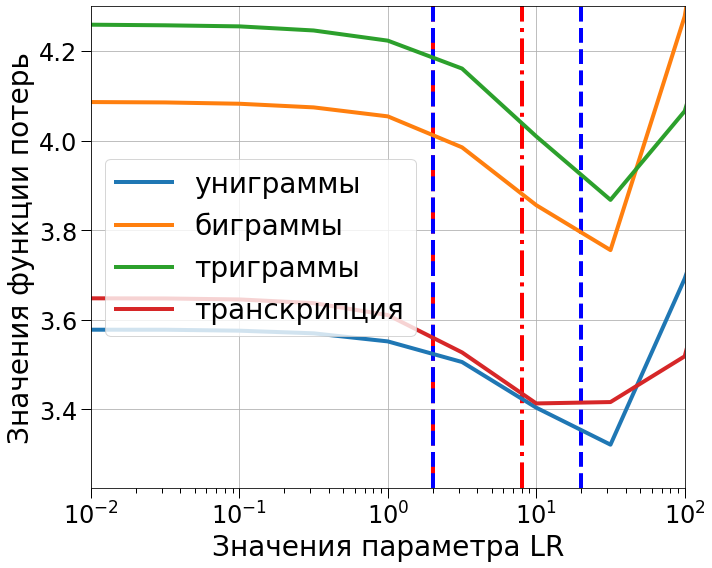

In [3]:
#LR Range Test plot
MODEL = 'GRU'#'LSTM'#
SEED = 42
VEC = {'unigrams': 'униграммы', 'bigrams': 'биграммы', 
       'trigrams': 'триграммы', 'transcription': 'транскрипция'}

fig, ax = plt.subplots(1, figsize=(10, 8), )
ax.axvline(x=2, linestyle = '-.', color='red', lw=4)
ax.axvline(x=8, linestyle = '-.', color='red', lw=4)
ax.axvline(x=2, linestyle = '--', color='blue', lw=4)
ax.axvline(x=20, linestyle = '--', color='blue', lw=4)

for i in VEC.keys():
    lr = np.load('lr_{0}_{1}_{2}.npy'.format(MODEL, i, SEED))
    loss = np.load('lr_loss_{0}_{1}_{2}.npy'.format(MODEL, i, SEED))
    ax.plot(lr, loss, label=VEC[i], lw=4)
ax.set_ylabel('Значения функции потерь', fontsize=28)
ax.set_xlabel('Значения параметра LR', fontsize=28)
ax.set_xscale('log')
ax.set_xlim(left=0.01, right=100)
ax.set_ylim(top=4.3)
ax.legend(loc='best', fontsize=28, )
ax.tick_params(labelsize=24, length=10, width=1)
ax.tick_params(which='minor', length=5, width=1)
ax.grid(True)

fig.tight_layout()
plt.savefig('LRRT_{}'.format(MODEL))
plt.show()
plt.close(fig)

Для построения графиков точности модели на тестовой выборке от количества эпох обучения необходимо установить параметры:
- для рисунка 3.3 (а):
    - MODEL = 'LSTM'
    - VEC = 'unigrams'
    - LR = [10, 20]
    - CLR_MODE = []
    - OPT_ADAMW = False
- для рисунка 3.3 (б):
    - MODEL = 'GRU'
    - VEC = 'unigrams'
    - LR = [4, 5]
    - CLR_MODE = ['exp_range']
    - OPT_ADAMW = False 
- для рисунка 3.4 (а):
    - MODEL = 'LSTM'
    - VEC = 'bigrams'
    - LR = [4]
    - CLR_MODE = []
    - OPT_ADAMW = True
- для рисунка 3.4 (б):
    - MODEL = 'GRU'
    - VEC = 'bigrams'
    - LR = [2]
    - CLR_MODE = ['triangular']
    - OPT_ADAMW = False
- для рисунка 3.5 (а):
    - MODEL = 'LSTM'
    - VEC = 'trigrams'
    - LR = [10, 20]
    - CLR_MODE = ['triangular2']
    - OPT_ADAMW = False
- для рисунка 3.5 (б):
    - MODEL = 'GRU'
    - VEC = 'trigrams'
    - LR = [5]
    - CLR_MODE = ['exp_range']
    - OPT_ADAMW = False 
- для рисунка 3.6 (а):
    - MODEL = 'LSTM'
    - VEC = 'transcription'
    - LR = [8]
    - CLR_MODE = []
    - OPT_ADAMW = False
- для рисунка 3.6 (б):
    - MODEL = 'GRU'
    - VEC = 'transcription'
    - LR = [2]
    - CLR_MODE = ['triangular']
    - OPT_ADAMW = False 

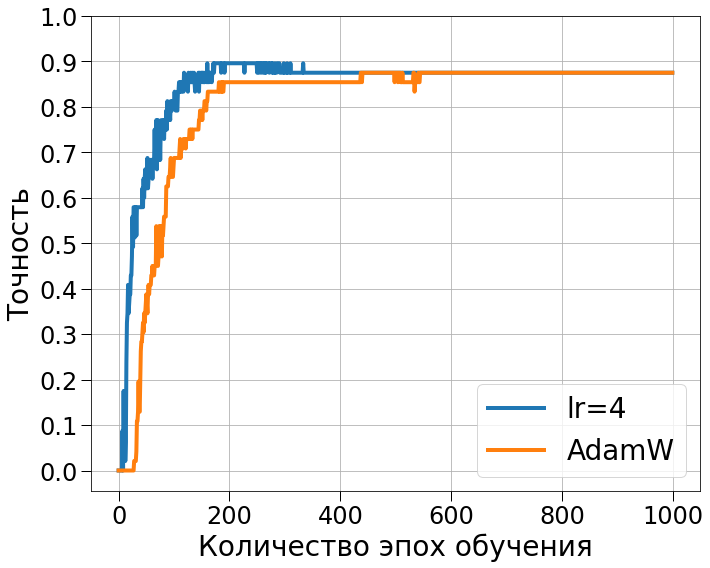

In [5]:
MODEL = 'LSTM'#'GRU'#
SEED = 42
VEC = 'bigrams'
VEC_DICT = {'unigrams': 'униграммы', 'bigrams': 'биграммы',
            'trigrams': 'триграммы', 'transcription': 'транскрипция'}

LR = [4]
CLR_MODE = []#'exp_range''triangular'
OPT_ADAMW = True

fig, ax = plt.subplots(1, figsize=(10, 8), )

for lr in LR:
    val_acc = np.load('val_acc_{0}_{1}_{2}_const_lr_{3}.npy'.format(MODEL, VEC, 
                                                                    SEED, lr))
    ax.plot(np.arange(len(val_acc)), val_acc, label='lr={}'.format(lr), lw=4)
for mode in CLR_MODE:
    val_acc = np.load('val_acc_{0}_{1}_{2}_clr_{3}.npy'.format(MODEL, VEC, 
                                                                    SEED, mode))
    ax.plot(np.arange(len(val_acc)), val_acc, label=mode, lw=4)
if OPT_ADAMW:
    val_acc = np.load('val_acc_{0}_{1}_{2}_AdamW.npy'.format(MODEL, VEC, SEED))
    ax.plot(np.arange(len(val_acc)), val_acc, label='AdamW', lw=4)
    
ax.set_ylabel('Точность', fontsize=28)
ax.set_xlabel('Количество эпох обучения', fontsize=28)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xscale('linear')
ax.legend(loc='lower right', fontsize=28)
ax.tick_params(labelsize=24, length=10, width=1)
ax.grid(True)

fig.tight_layout()
plt.show()